In [2]:
from google.colab import files
import io
import pandas as pd

print("Please upload adult.csv")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print("Uploaded file:", filename)

df = pd.read_csv(io.BytesIO(uploaded[filename]))
print("Shape:", df.shape)
print(df.head())
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 5)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


Please upload adult.csv


Saving adult.csv to adult (1).csv
Uploaded file: adult (1).csv
Shape: (32561, 15)
   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356     

In [3]:

# Clean and rename columns
df_clean = df.replace("?", np.nan)
print("Original shape:", df.shape)
df_clean = df_clean.dropna()
print("After dropping missing:", df_clean.shape)

col_rename_map = {
    "education-num": "education.num",
    "marital-status": "marital.status",
    "hours-per-week": "hours.per.week",
    "capital-gain": "capital.gain",
    "capital-loss": "capital.loss",
    "native-country": "native.country"
}
df_clean = df_clean.rename(columns=col_rename_map)
print("Columns now:", df_clean.columns.tolist())


Original shape: (32561, 15)
After dropping missing: (30162, 15)
Columns now: ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']


In [4]:

# Target
df_clean["income_binary"] = (df_clean["income"].str.strip() == ">50K").astype(int)

feature_cols = [
    "age", "workclass", "fnlwgt", "education", "education.num",
    "marital.status", "occupation", "relationship", "race", "sex",
    "capital.gain", "capital.loss", "hours.per.week", "native.country"
]

X = df_clean[feature_cols]
y = df_clean["income_binary"]
sensitive_sex = df_clean["sex"].copy()

print("X shape:", X.shape, " y shape:", y.shape)

numeric_features = [
    "age", "fnlwgt", "education.num",
    "capital.gain", "capital.loss", "hours.per.week"
]

categorical_features = [
    "workclass", "education", "marital.status", "occupation",
    "relationship", "race", "sex", "native.country"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X_train, X_test, y_train, y_test, sex_train, sex_test = train_test_split(
    X, y, sensitive_sex,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score



X shape: (30162, 14)  y shape: (30162,)
Train: (24129, 14) Test: (6033, 14)


In [5]:
# Decision Tree baseline
dt_clf = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=None)

dt_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", dt_clf)
    ]
)

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("=== Decision Tree ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# Random Forest baseline
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", rf_clf)
    ]
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n=== Random Forest (100 trees) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


=== Decision Tree ===
Accuracy: 0.8158461793469253
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4531
           1       0.63      0.62      0.63      1502

    accuracy                           0.82      6033
   macro avg       0.75      0.75      0.75      6033
weighted avg       0.82      0.82      0.82      6033


=== Random Forest (100 trees) ===
Accuracy: 0.8559588927565058
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4531
           1       0.75      0.63      0.69      1502

    accuracy                           0.86      6033
   macro avg       0.82      0.78      0.80      6033
weighted avg       0.85      0.86      0.85      6033



In [6]:
# ==========================
# Hyperparameter experiments
# ==========================

param_n_estimators = [50, 100, 200]
param_max_depth = [None, 10, 20]

results = []

for n_est in param_n_estimators:
    for max_depth in param_max_depth:
        clf = RandomForestClassifier(
            n_estimators=n_est,
            max_depth=max_depth,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        model = Pipeline(
            steps=[
                ("preprocess", preprocessor),
                ("clf", clf)
            ]
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        results.append({
            "n_estimators": n_est,
            "max_depth": max_depth,
            "accuracy": acc
        })

        print(f"Grid: n_estimators={n_est}, max_depth={max_depth}, accuracy={acc:.4f}")

results_df = pd.DataFrame(results)
results_df


Grid: n_estimators=50, max_depth=None, accuracy=0.8560
Grid: n_estimators=50, max_depth=10, accuracy=0.8586
Grid: n_estimators=50, max_depth=20, accuracy=0.8666
Grid: n_estimators=100, max_depth=None, accuracy=0.8560
Grid: n_estimators=100, max_depth=10, accuracy=0.8618
Grid: n_estimators=100, max_depth=20, accuracy=0.8681
Grid: n_estimators=200, max_depth=None, accuracy=0.8604
Grid: n_estimators=200, max_depth=10, accuracy=0.8621
Grid: n_estimators=200, max_depth=20, accuracy=0.8672


,n_estimators,max_depth,accuracy
0,50,NaN,0.855959
1,50,10.0,0.858611
2,50,20.0,0.866567
3,100,NaN,0.855959
4,100,10.0,0.861760
5,100,20.0,0.868059
6,200,NaN,0.860434
7,200,10.0,0.862092
8,200,20.0,0.867230


In [7]:
# Plot accuracy vs n_estimators for each max_depthimport numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # should already be imported, but just in case



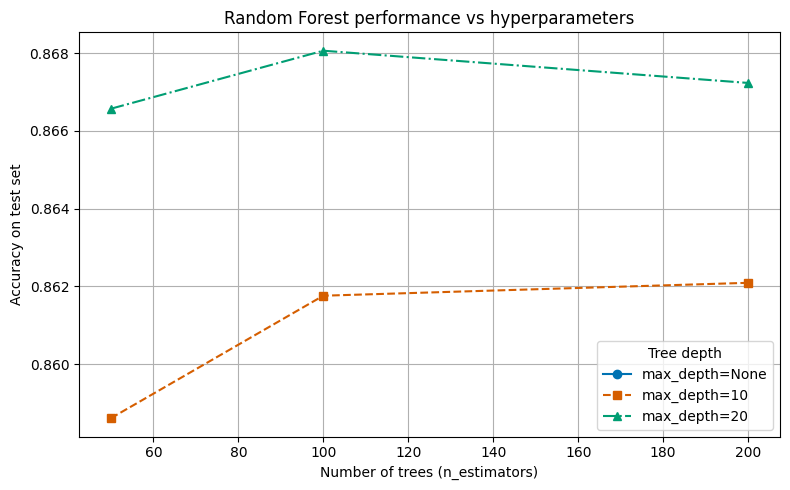

In [8]:
# Accessible plotting for hyperparameter results

plt.figure()

linestyles = {
    None: "-",
    10: "--",
    20: "-."
}

markers = {
    None: "o",
    10: "s",
    20: "^"
}

colors = {
    None: "#0072B2",  # blue
    10: "#D55E00",   # orange
    20: "#009E73"    # green
}

for raw_depth in results_df["max_depth"].unique():
    # Handle NaN (which corresponds to max_depth=None)
    if pd.isna(raw_depth):
        depth_key = None
        depth_label = "max_depth=None"
    else:
        depth_key = int(raw_depth)
        depth_label = f"max_depth={depth_key}"

    subset = results_df[results_df["max_depth"] == raw_depth]

    plt.plot(
        subset["n_estimators"],
        subset["accuracy"],
        marker=markers[depth_key],
        linestyle=linestyles[depth_key],
        color=colors[depth_key],
        label=depth_label
    )

plt.xlabel("Number of trees (n_estimators)")
plt.ylabel("Accuracy on test set")
plt.title("Random Forest performance vs hyperparameters")
plt.legend(title="Tree depth")
plt.grid(True)
plt.tight_layout()
plt.show()



In [9]:
# ==========================
# Feature importances
# ==========================

# Choose final hyperparameters (you can tweak these based on results_df)
BEST_N_ESTIMATORS = 200
BEST_MAX_DEPTH = 20  # or None if that looked better

best_rf_clf = RandomForestClassifier(
    n_estimators=BEST_N_ESTIMATORS,
    max_depth=BEST_MAX_DEPTH,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

best_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", best_rf_clf)
    ]
)

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

print("Best RF accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Best RF accuracy: 0.8672302337145699
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4531
           1       0.80      0.63      0.70      1502

    accuracy                           0.87      6033
   macro avg       0.84      0.79      0.81      6033
weighted avg       0.86      0.87      0.86      6033



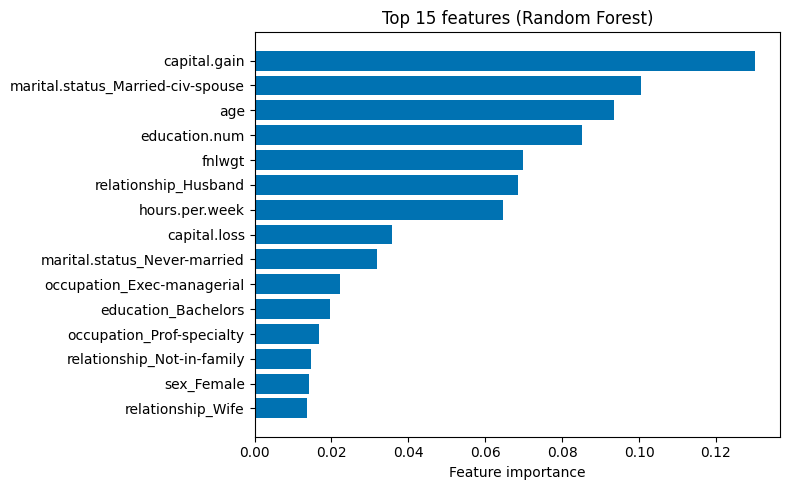

In [10]:
# Get feature importances from the trained Random Forest

ohe = best_model.named_steps["preprocess"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, ohe_feature_names])

importances = best_model.named_steps["clf"].feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feature_importance_df.head(20)
top_n = 15
top_features = feature_importance_df.head(top_n).sort_values("importance")

plt.figure()
plt.barh(top_features["feature"], top_features["importance"], color="#0072B2")
plt.xlabel("Feature importance")
plt.title(f"Top {top_n} features (Random Forest)")
plt.tight_layout()
plt.show()


In [11]:
# ==========================
# Fairness analysis by sex
# ==========================

results = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_best,
    "sex": sex_test
})

def recall_for_positive(g):
    y_true = g["y_true"]
    y_pred = g["y_pred"]
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else np.nan

group_accuracy = results.groupby("sex").apply(
    lambda g: accuracy_score(g["y_true"], g["y_pred"])
)

group_recall_pos = results.groupby("sex").apply(recall_for_positive)

print("=== Group-wise accuracy by sex (Best RF) ===")
print(group_accuracy)

print("\n=== Group-wise recall for >50K by sex (Best RF) ===")
print(group_recall_pos)
results = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_best,
    "sex": sex_test
})


=== Group-wise accuracy by sex (Best RF) ===
sex
Female    0.930016
Male      0.837719
dtype: float64

=== Group-wise recall for >50K by sex (Best RF) ===
sex
Female    0.567568
Male      0.635156
dtype: float64


/tmp/ipython-input-1352662600.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_accuracy = results.groupby("sex").apply(
/tmp/ipython-input-1352662600.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_recall_pos = results.groupby("sex").apply(recall_for_positive)


In [12]:
# choose final hyperparameters
BEST_N_ESTIMATORS = 200
BEST_MAX_DEPTH = 20  # or None if that’s what you want

best_rf_clf = RandomForestClassifier(
    n_estimators=BEST_N_ESTIMATORS,
    max_depth=BEST_MAX_DEPTH,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

best_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", best_rf_clf)
    ]
)

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

print("Best RF accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))
X_train, X_test, y_train, y_test, sex_train, sex_test = train_test_split(
    X, y, sensitive_sex,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)
results = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_best,
    "sex": sex_test
})
...


Best RF accuracy: 0.8672302337145699
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4531
           1       0.80      0.63      0.70      1502

    accuracy                           0.87      6033
   macro avg       0.84      0.79      0.81      6033
weighted avg       0.86      0.87      0.86      6033



Ellipsis